In [94]:
#tf.keras.backend.clear_session()

In [95]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import pathlib
from tensorflow.keras.models import Model

In [96]:
tf.keras.backend.clear_session()

In [97]:
path = 'C:/Users/sbuser/Documents/niraj/UV_Sorted-20250724T191839Z-1-001/UV_Sorted/combine/Moist_Images'

In [98]:
images = (os.listdir(path))


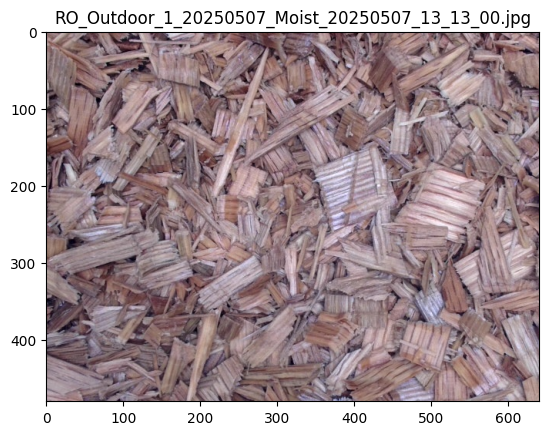

In [99]:
for img_name in images:
    img_path = os.path.join(path, img_name)
    image = cv2.imread(img_path)
    if image is not None:
        # Convert the image from BGR to RGB for displaying with matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.title(img_name)
        plt.show()
        #plt.axis('off')
        break
    else:
        print(f"Error loading image: {img_path}")

In [100]:
image_path  = 'C:/Users/sbuser/Documents/niraj/UV_Sorted-20250724T191839Z-1-001/UV_Sorted/combine/'

In [101]:
image_path = pathlib.Path(image_path)
image_path

WindowsPath('C:/Users/sbuser/Documents/niraj/UV_Sorted-20250724T191839Z-1-001/UV_Sorted/combine')

In [102]:
all_db = tf.keras.preprocessing.image_dataset_from_directory(
    image_path,
    batch_size = 8,
    image_size = (299,299),
    shuffle = True,
    seed = 7,

)

Found 1724 files belonging to 2 classes.


In [103]:
class_name = all_db.class_names
class_name

['Dry_Images', 'Moist_Images']

In [104]:
total = len(all_db)
total

216

In [105]:
train_size = int (0.8 * total)
train_db = all_db.take(train_size)
valid_size = int(0.1*total)
valid_db = all_db.skip(train_size).take(valid_size)
test_size = int(0.1*total)
test_db = all_db.skip(train_size).skip(valid_size)

In [106]:
len(test_db), len(valid_db), len(train_db)

(23, 21, 172)

In [107]:
AUTOTUNE = tf.data.AUTOTUNE
train_db =  train_db.cache().shuffle(1000).prefetch(AUTOTUNE)
valid_db = valid_db.cache().prefetch(AUTOTUNE)
test_db = test_db.cache().prefetch(AUTOTUNE)

In [108]:
base_model = tf.keras.applications.Xception(
    include_top = False,
    weights = 'imagenet',
    input_shape = (299,299,3)
)

In [109]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [110]:
base_model.trainable = False

In [111]:
pre_process_layers = keras.Sequential(
    [
        keras.layers.Resizing(299,299),
        keras.layers.RandomFlip('horizontal_and_vertical'),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.1),
        #keras.layers.Rescaling(1./255)
    ]
)

In [112]:
from tensorflow.keras.applications.xception import preprocess_input

In [113]:
inputs = keras.layers.Input(shape = (None,None,3))
x = pre_process_layers(inputs)
x = keras.layers.Lambda(preprocess_input)(x)
x = base_model(x, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(300, activation='relu', kernel_regularizer= keras.regularizers.L2(0.001))(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(200, activation = 'relu', kernel_regularizer= keras.regularizers.L2(0.001))(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
output = keras.layers.Dense(2, activation= 'softmax')(x)
dry_wet_model = Model(inputs, output)

In [114]:
dry_wet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 lambda (Lambda)             (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 300)               614700    
                                                             

In [115]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, restore_best_weights= True)

In [116]:
class_weights = {
    0: 1.0,  # Dry class
    1: 1.5   # Moist class → increase its importance
}


In [117]:
dry_wet_model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history1 = dry_wet_model.fit(train_db, validation_data= valid_db, epochs = 100, callbacks= early_stop, class_weight = class_weights)

Epoch 1/100
172/172 [==============================] - 18s 90ms/step - loss: 1.2106 - accuracy: 0.5254 - val_loss: 0.8750 - val_accuracy: 0.5714
Epoch 2/100
172/172 [==============================] - 14s 84ms/step - loss: 0.9739 - accuracy: 0.5327 - val_loss: 0.7955 - val_accuracy: 0.6012
Epoch 3/100
172/172 [==============================] - 15s 85ms/step - loss: 0.9032 - accuracy: 0.5327 - val_loss: 0.7529 - val_accuracy: 0.5655
Epoch 4/100
172/172 [==============================] - 15s 84ms/step - loss: 0.8683 - accuracy: 0.5225 - val_loss: 0.7349 - val_accuracy: 0.5893
Epoch 5/100
172/172 [==============================] - 14s 83ms/step - loss: 0.8481 - accuracy: 0.5342 - val_loss: 0.7210 - val_accuracy: 0.5595
Epoch 6/100
172/172 [==============================] - 15s 84ms/step - loss: 0.8270 - accuracy: 0.5160 - val_loss: 0.7030 - val_accuracy: 0.5595
Epoch 7/100
172/172 [==============================] - 15s 85ms/step - loss: 0.8135 - accuracy: 0.5451 - val_loss: 0.7026 - val_ac

In [118]:
dry_wet_model.evaluate(test_db)

23/23 [==============================] - 2s 54ms/step - loss: 0.6286 - accuracy: 0.5556


[0.6285833716392517, 0.5555555820465088]

In [119]:
yp = dry_wet_model.predict(test_db)

23/23 [==============================] - 2s 62ms/step


In [120]:
y_predict = np.argmax(yp, axis = 1)

In [121]:
y_test = []
for x, y in test_db:
  y_test.extend(y.numpy())

In [122]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.59      0.33      0.42        89
           1       0.54      0.78      0.64        91

    accuracy                           0.56       180
   macro avg       0.57      0.55      0.53       180
weighted avg       0.57      0.56      0.53       180



In [123]:
history_dict = history1.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [124]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

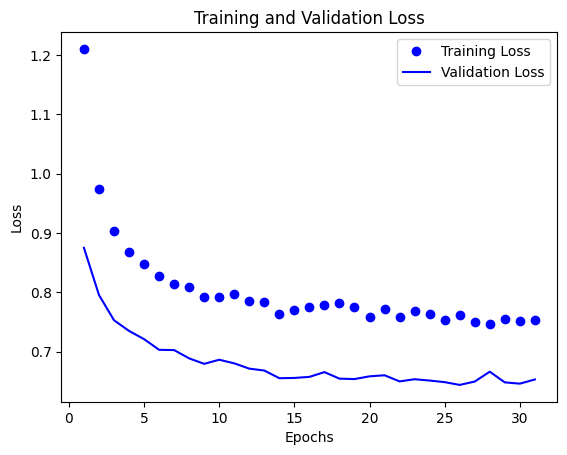

In [125]:
plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.show()

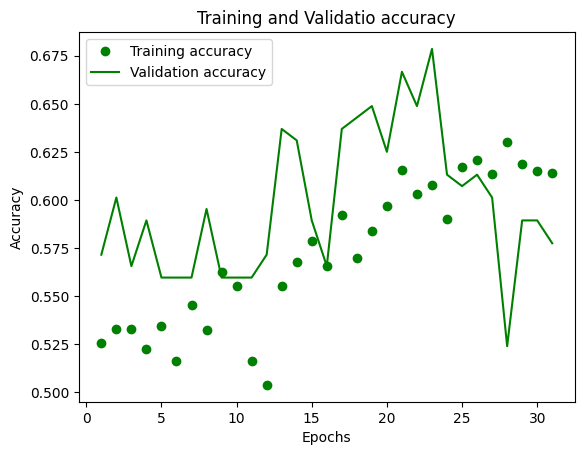

In [126]:
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'go', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'g', label = 'Validation accuracy')
plt.title("Training and Validatio accuracy")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [127]:
base_model.trainable = True

In [128]:
# n = 0
# for layer in base_model.layers[-80:]:
#   if not isinstance(layer, keras.layers.BatchNormalization):
#     layer.trainable = True
#     print(layer.name)
#     n+=1

# print(n)

In [129]:
inputs = keras.layers.Input(shape = (None,None,3))
x = pre_process_layers(inputs)
x = keras.layers.Lambda(preprocess_input)(x)
x = base_model(x, training = True)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(300, activation='relu', kernel_regularizer= keras.regularizers.L2(0.001))(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(200, activation = 'relu', kernel_regularizer= keras.regularizers.L2(0.001))(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(100, activation='relu', kernel_regularizer= keras.regularizers.L2(0.001))(x)
x = keras.layers.Dropout(0.2)(x)
output = keras.layers.Dense(2, activation= 'softmax')(x)
dry_wet_model = Model(inputs, output)

In [130]:
dry_wet_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 5e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history2 = dry_wet_model.fit(train_db, validation_data= valid_db, epochs = 100, callbacks= early_stop
)

Epoch 1/100
172/172 [==============================] - 48s 263ms/step - loss: 1.5326 - accuracy: 0.5654 - val_loss: 1.5022 - val_accuracy: 0.5952
Epoch 2/100
172/172 [==============================] - 44s 258ms/step - loss: 1.4162 - accuracy: 0.6868 - val_loss: 1.4410 - val_accuracy: 0.6190
Epoch 3/100
172/172 [==============================] - 45s 260ms/step - loss: 1.3187 - accuracy: 0.7435 - val_loss: 1.3291 - val_accuracy: 0.7202
Epoch 4/100
172/172 [==============================] - 46s 269ms/step - loss: 1.2470 - accuracy: 0.7936 - val_loss: 1.3237 - val_accuracy: 0.7083
Epoch 5/100
172/172 [==============================] - 46s 269ms/step - loss: 1.1678 - accuracy: 0.8154 - val_loss: 1.2848 - val_accuracy: 0.7500
Epoch 6/100
172/172 [==============================] - 46s 266ms/step - loss: 1.1189 - accuracy: 0.8299 - val_loss: 1.2384 - val_accuracy: 0.7857
Epoch 7/100
172/172 [==============================] - 46s 266ms/step - loss: 1.0549 - accuracy: 0.8554 - val_loss: 1.2287 -

In [131]:
dry_wet_model.evaluate(test_db)

23/23 [==============================] - 1s 35ms/step - loss: 1.2066 - accuracy: 0.7778


[1.20659601688385, 0.7777777910232544]

In [132]:
yp = dry_wet_model.predict(test_db)

23/23 [==============================] - 1s 33ms/step


In [133]:
y_predict = np.argmax(yp, axis = 1)

In [134]:
y_test = []
for x, y in test_db:
  y_test.extend(y.numpy())

In [135]:
n = 0
for i in range(len(y_predict)):
  if y_predict[i] != y_test[i]:
    print(f'Y__predicted: {class_name[y_predict[i]]} Y_truth: {class_name[y_test[i]]}')
    n = n + 1
print(n)

Y__predicted: Dry_Images Y_truth: Moist_Images
Y__predicted: Dry_Images Y_truth: Moist_Images
Y__predicted: Moist_Images Y_truth: Dry_Images
Y__predicted: Moist_Images Y_truth: Dry_Images
Y__predicted: Moist_Images Y_truth: Dry_Images
Y__predicted: Dry_Images Y_truth: Moist_Images
Y__predicted: Moist_Images Y_truth: Dry_Images
Y__predicted: Moist_Images Y_truth: Dry_Images
Y__predicted: Dry_Images Y_truth: Moist_Images
Y__predicted: Dry_Images Y_truth: Moist_Images
Y__predicted: Dry_Images Y_truth: Moist_Images
Y__predicted: Moist_Images Y_truth: Dry_Images
Y__predicted: Dry_Images Y_truth: Moist_Images
Y__predicted: Moist_Images Y_truth: Dry_Images
Y__predicted: Moist_Images Y_truth: Dry_Images
Y__predicted: Moist_Images Y_truth: Dry_Images
Y__predicted: Moist_Images Y_truth: Dry_Images
Y__predicted: Dry_Images Y_truth: Moist_Images
Y__predicted: Dry_Images Y_truth: Moist_Images
Y__predicted: Dry_Images Y_truth: Moist_Images
Y__predicted: Dry_Images Y_truth: Moist_Images
Y__predicted:

In [136]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78        89
           1       0.79      0.76      0.78        91

    accuracy                           0.78       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.78      0.78      0.78       180



<Axes: >

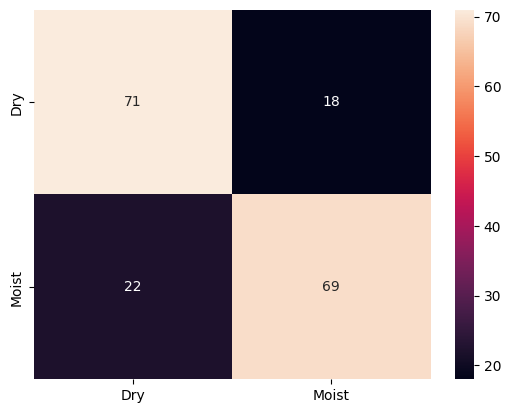

In [137]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Dry', 'Moist'], yticklabels=['Dry', 'Moist'])


In [138]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [139]:
loss_values = history_dict2['loss']
val_loss_values = history_dict2['val_loss']
epochs = range(1, len(loss_values) + 1)

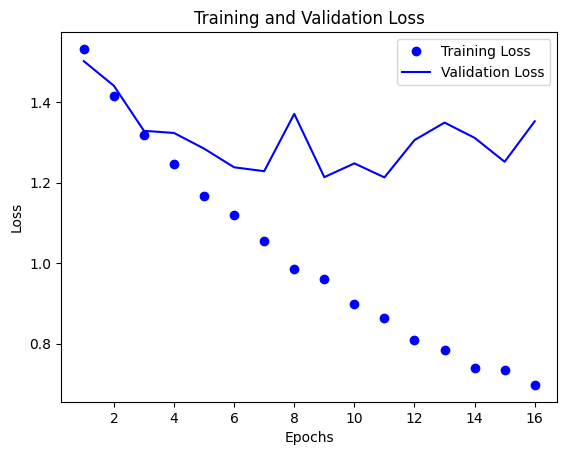

In [140]:
plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()
plt.show()

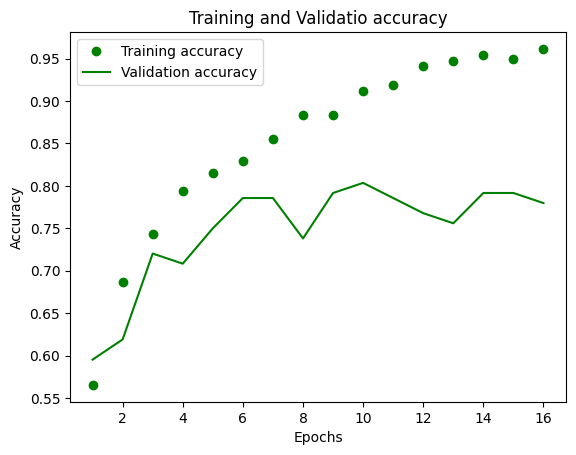

In [141]:
plt.clf()
acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
plt.plot(epochs, acc, 'go', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'g', label = 'Validation accuracy')
plt.title("Training and Validatio accuracy")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.show()